# Load the modules



In [194]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb
import anndata as ad
import scanpy as sc
import moscot as mt
from moscot.problems.space import AlignmentProblem
import squidpy as sq

# Load the MSI and the RNA data

In [197]:
# Define the data_loader
def load_msi_data(file_path: str, spatial_cols: list = [0, 1], technology: str = None) -> ad.AnnData:
    """
    Load spatial transcriptomics data from a CSV file into an AnnData object.

    Parameters:
    - file_path: str, the path to the CSV file.
    - spatial_cols: list, indices of the columns that contain spatial coordinates.
    - technology: str, optional, label for the 'technology' field in obs.

    Returns:
    - adata: an AnnData object with the data and spatial coordinates.
    """

    # Load the CSV file
    df = pd.read_csv(file_path)

    # Extract the spatial location information
    location = df.iloc[:, spatial_cols]

    # Extract the data part (excluding spatial coordinates)
    data = df.drop(df.columns[spatial_cols], axis=1)

    # Create an AnnData object with the data
    adata = ad.AnnData(data)

    # Add spatial information to the AnnData object
    adata.obsm['spatial'] = location.values

    # Add technology label
    adata.obs['technology'] = 'MSI'
    adata.var['technology'] = 'MSI'

    # If technology label is provided, add it as an attribute to obs
    if technology is not None:
        adata.obs['technology'] = technology

    return adata

In [198]:
#Define data pathes
path_msi = '/content/drive/MyDrive/sma/V11L12-038/V11L12-038_A1/output_data/V11L12-038_A1_MSI/V11L12-038_A1.Visium.DHB.220826_smamsi.csv'
path_rna = '/content/drive/MyDrive/sma/V11L12-038/V11L12-038_A1/output_data/V11L12-038_A1_RNA/outs'

In [199]:
#Load MSI and VISIUM data
adata_msi = load_msi_data(path_msi)
adata_rna = sc.read_visium(path_rna)

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [200]:
# Preprocessing steps for MSI data
adata_msi.obsm['raw_counts'] = adata_msi.X.copy()
sc.pp.normalize_total(adata_msi, inplace=True, exclude_highly_expressed=False)
sc.pp.log1p(adata_msi)
sc.pp.highly_variable_genes(adata_msi, flavor='seurat', n_top_genes=500, inplace=True)
sc.pp.pca(adata_msi, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_msi, n_neighbors=5)
sc.tl.umap(adata_msi)
sc.tl.leiden(adata_msi, key_added='clusters')

# Add spatially variable metabolites
sq.gr.spatial_neighbors(adata_msi)
sq.gr.spatial_autocorr(adata_msi, mode='moran')

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


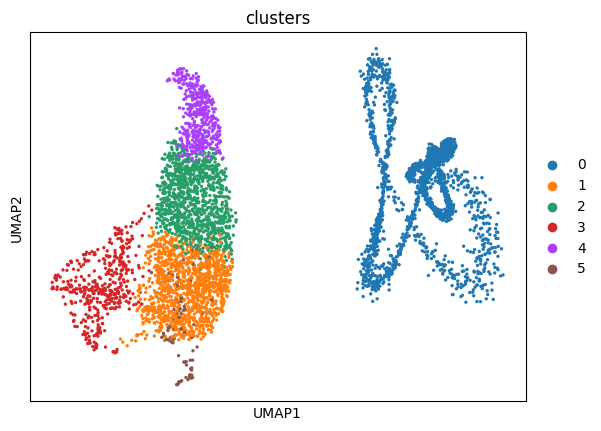

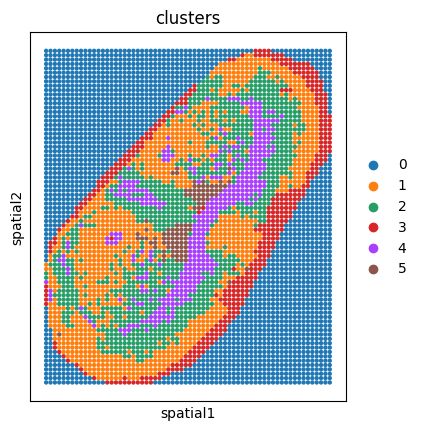

In [201]:
#Plotting of the MSI data
sc.pl.umap(adata_msi, color='clusters', palette=sc.pl.palettes.default_20)
sc.pl.spatial(adata_msi, img_key = "hires", color="clusters", spot_size=1)

In [202]:
#remove the "emplty cluster - 0, since there are no datapoints there
idx_to_remove = adata_msi.obs["clusters"][adata_msi.obs["clusters"] == "0"]
keep_cells_mask = ~adata_msi.obs.index.isin(idx_to_remove.index)
adata_msi = adata_msi[keep_cells_mask, :]

In [203]:
#remove the "emplty cluster - 3 after visual inspection of the VISIUM slide and identification of the boarders of the slide
idx_to_remove = adata_msi.obs["clusters"][adata_msi.obs["clusters"] == "3"]
keep_cells_mask = ~adata_msi.obs.index.isin(idx_to_remove.index)
adata_msi = adata_msi[keep_cells_mask, :]

In [204]:
#Define RNA pp steps
def rna_pp(adata_rna: ad.AnnData) -> ad.AnnData:
    """
    Preprocess RNA data by applying filtering and quality control steps,
    then return a cleaned and preprocessed AnnData object.

    Parameters:
    - adata_rna: AnnData object containing RNA data.

    Returns:
    - adata_rna: Cleaned and preprocessed AnnData object.
    """

    # Make variable names unique
    adata_rna.var_names_make_unique()

    # Plot the top 20 highest-expressed genes
    sc.pl.highest_expr_genes(adata_rna, n_top=20)

    # Identify mitochondrial genes
    mito_genes = adata_rna.var_names.str.startswith('MT-')

    # Calculate the fraction of mitochondrial gene counts for each cell
    adata_rna.obs['mt_frac'] = np.sum(
        adata_rna[:, mito_genes].X, axis=1).A1 / np.sum(adata_rna.X, axis=1).A1

    # Add the total counts per cell as an observation annotation
    adata_rna.obs['total_counts'] = adata_rna.X.sum(axis=1).A1

    # Filter cells based on minimum and maximum total counts
    sc.pp.filter_cells(adata_rna, min_counts=1000)
    print(f'Number of cells after min count filter: {adata_rna.n_obs}')

    sc.pp.filter_cells(adata_rna, max_counts=35000)
    print(f'Number of cells after max count filter: {adata_rna.n_obs}')

    # Optional: filter cells based on mitochondrial fraction (e.g., < 20%)
    # Uncomment if needed
    adata_rna = adata_rna[adata_rna.obs['mt_frac'] < 0.2]
    print(f'Number of cells after MT filter: {adata_rna.n_obs}')
    sc.pp.filter_cells(adata_rna, min_genes = 1000)
    # Filter genes based on minimum number of cells in which they are expressed
    sc.pp.filter_genes(adata_rna, min_cells=10)
    print(f'Number of genes after cell filter: {adata_rna.n_vars}')

    return adata_rna


In [205]:
adata_rna

AnnData object with n_obs × n_vars = 2856 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

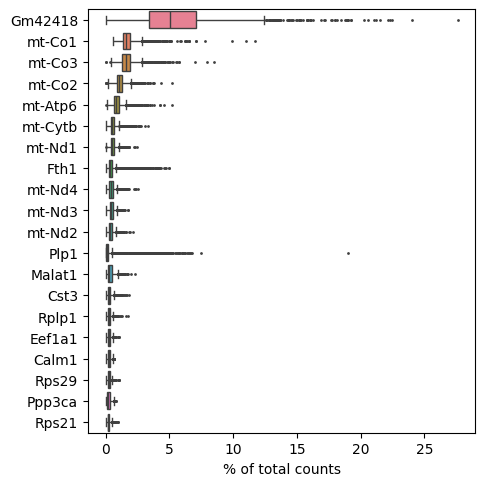

Number of cells after min count filter: 2817
Number of cells after max count filter: 2815
Number of cells after MT filter: 2815


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Number of genes after cell filter: 14479


In [206]:
adata_rna = rna_pp(adata_rna)

In [207]:
adata_rna.obsm['raw_counts'] = adata_rna.X.copy()
# Normalization and log-transformation
sc.pp.normalize_total(adata_rna, inplace=True)
sc.pp.log1p(adata_rna)
# Identify highly variable genes
sc.pp.highly_variable_genes(adata_rna, flavor='seurat', n_top_genes=2000, inplace=True)
# Dimensionality reduction using PCA
sc.pp.pca(adata_rna, n_comps=50, use_highly_variable=True, svd_solver='arpack')
# Construct a neighborhood graph
sc.pp.neighbors(adata_rna, n_neighbors=100)
# Compute UMAP embedding
sc.tl.umap(adata_rna)
# Leiden clustering
sc.tl.leiden(adata_rna, key_added='clusters')
# Add technology lable
adata_rna.obs['technology'] = 'RNA'
adata_rna.var['technology'] = 'RNA'
# Add spatially variable genes
sq.gr.spatial_neighbors(adata_rna)
sq.gr.spatial_autocorr(adata_rna, mode='moran')

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


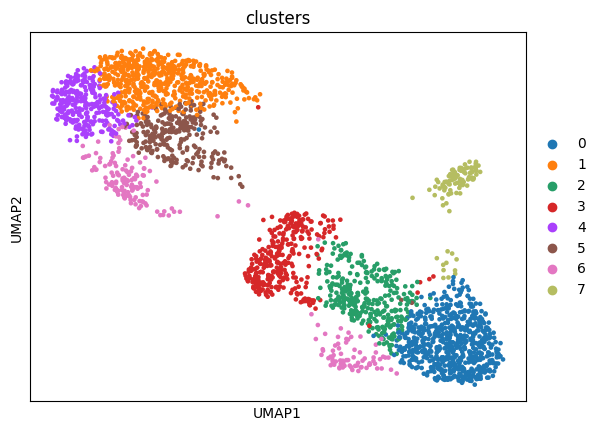

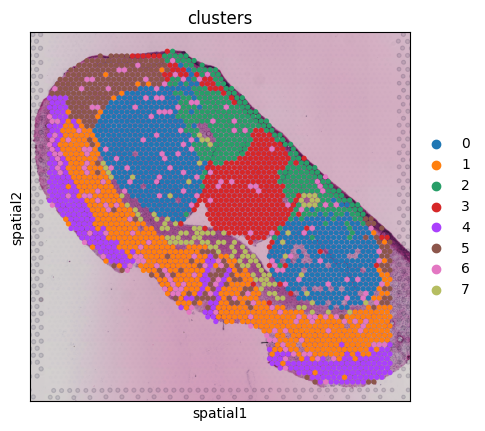

In [208]:
#Ploting of the RNA data
sc.pl.umap(adata_rna, color='clusters', palette=sc.pl.palettes.default_20)
sc.pl.spatial(adata_rna, img_key = "hires", color="clusters", size=1.5)

In [226]:
adata_rna.uns["moranI"].head()

,I,pval_norm,var_norm,pval_norm_fdr_bh
Penk,0.752875,0.0,0.000139,0.0
Nrgn,0.709952,0.0,0.000139,0.0
Slc17a7,0.683989,0.0,0.000139,0.0
Gm42418,0.681824,0.0,0.000139,0.0
Cck,0.650221,0.0,0.000139,0.0


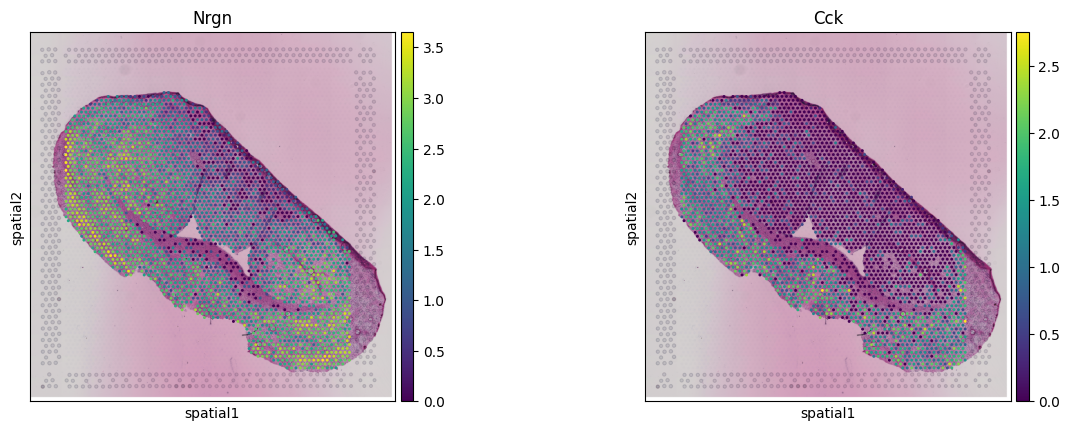

In [228]:
sq.pl.spatial_scatter(adata_rna, color=["Nrgn", "Cck"])

# Run MOSCOT to align the slides

In [224]:
#to run MOSCOT both anndatas need to be concatanated first
adata_combined = ad.concat([adata_rna, adata_msi], join='outer', merge='first', label='technology', keys=['RNA', 'MSI'])

In [225]:
#the AlignmentProblem preparation
ap = AlignmentProblem(adata=adata_combined)
ap = ap.prepare(batch_key="technology", policy="sequential")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   


MOSCOT provides the best alignment results when the datasets have the same shape (number of obs), so please double-check and look into RNA and MSI pp steps to maybe include or exclude some cells from the alignment

In [229]:
# it’s important to take into consideration the alpha value, which balances the weight of each loss (“unique” vs. “shared” spaces).
# With alpha close to the “shared” space loss is weighted more, with alpha close to 1 the “unique” space loss is balanced more.
# It is suggested to try various values that might be more fitting to the specific use case.
ap = ap.solve(alpha=0.9)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(2686, 2681)].                                          


/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


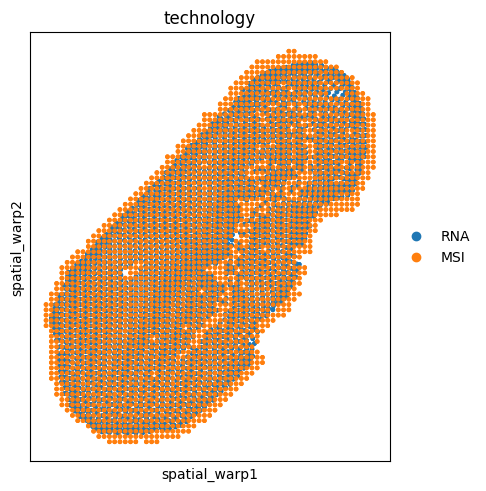

In [230]:
ap.align(reference="MSI", key_added="spatial_warp")
sq.pl.spatial_scatter(
    adata_combined, shape=None, spatial_key="spatial_warp", library_id="technology", color="technology"
)

# Save new coordinates to the anndatas

In [235]:
def copy_spatial_warp(adata_combined, adata_rna, adata_msi):
    """
    Copies the 'spatial_warp' coordinates from adata_combined to the original
    adata_rna and adata_msi AnnData objects based on their matching observations.

    Parameters:
    - adata_combined: The concatenated AnnData object containing both 'RNA' and 'MSI' data.
    - adata_rna: The original AnnData object for RNA data.
    - adata_msi: The original AnnData object for MSI data.

    Returns:
    - None (modifies adata_rna and adata_msi in place).
    """

    # Copy 'spatial_warp' for RNA
    adata_rna_spatial_warp = adata_combined[adata_combined.obs['technology'] == 'RNA'].obsm['spatial_warp']
    adata_rna.obsm['spatial_warp'] = adata_rna_spatial_warp

    # Copy 'spatial_warp' for MSI
    adata_msi_spatial_warp = adata_combined[adata_combined.obs['technology'] == 'MSI'].obsm['spatial_warp']
    adata_msi.obsm['spatial_warp'] = adata_msi_spatial_warp

# Usage example
copy_spatial_warp(adata_combined, adata_rna, adata_msi)

# Verify the update
print("adata_rna 'spatial_warp':", adata_rna.obsm['spatial_warp'])
print("adata_msi 'spatial_warp':", adata_msi.obsm['spatial_warp'])


adata_rna 'spatial_warp': [[41.0980072  19.65156746]
 [31.44471359 66.73149872]
 [34.86329651 64.11889648]
 ...
 [23.50485039 32.9280777 ]
 [34.33156586 56.76557541]
 [ 1.7169615  49.05052948]]
adata_msi 'spatial_warp': [[ 0. 49.]
 [ 0. 50.]
 [ 0. 51.]
 ...
 [62. 21.]
 [62. 22.]
 [62. 23.]]


In [238]:
adata_msi
adata_msi.write("/content/drive/MyDrive/sma/V11L12-038/V11L12-038_A1/V11L12-038_A1.MSI_MOSCOT.h5ad")

In [239]:
adata_rna
adata_rna.write("/content/drive/MyDrive/sma/V11L12-038/V11L12-038_A1/V11L12-038_A1.RNA_MOSCOT.h5ad")

# Matching the datasets
Find the closest points from adata_rna and adata_msi to then pair the gene expression to metabolic distribution at each matching point

In [241]:
from scipy.spatial import cKDTree

# Use the 'spatial_warp' coordinates
adata_rna_coords = adata_rna.obsm['spatial_warp']
adata_msi_coords = adata_msi.obsm['spatial_warp']

# Step 1: Build a spatial tree for `adata_rna`
tree_adata_rna = cKDTree(adata_rna_coords)

# Step 2: Query the tree to find the closest point in `adata_rna` for each point in `adata_msi`
distances, indices = tree_adata_rna.query(adata_msi_coords)

# Step 3: Create a DataFrame to show the matching pairs
import pandas as pd

matching_df = pd.DataFrame({
    'adata_msi_index': np.arange(len(adata_msi_coords)),
    'adata_msi_x': adata_msi_coords[:, 0],
    'adata_msi_y': adata_msi_coords[:, 1],
    'closest_adata_rna_index': indices,
    'adata_rna_x': adata_rna_coords[indices, 0],
    'adata_rna_y': adata_rna_coords[indices, 1],
    'distance': distances
})

In [242]:
matching_df

,adata_msi_index,adata_msi_x,adata_msi_y,closest_adata_rna_index,adata_rna_x,adata_rna_y,distance
0,0,0.0,49.0,2685,1.716962,49.050529,1.717705
1,1,0.0,50.0,78,1.593616,49.841583,1.601471
2,2,0.0,51.0,774,1.013646,51.582249,1.168970
3,3,0.0,52.0,774,1.013646,51.582249,1.096355
4,4,0.0,53.0,557,1.076599,52.458786,1.204980
...,...,...,...,...,...,...,...
2676,2676,62.0,19.0,192,60.567673,19.242273,1.452673
2677,2677,62.0,20.0,192,60.567673,19.242273,1.620405
2678,2678,62.0,21.0,982,60.257828,21.004404,1.742178
2679,2679,62.0,22.0,982,60.257828,21.004404,2.006583


In [243]:
output_path = "/content/drive/MyDrive/sma/V11L12-038/V11L12-038_A1/output_data/V11L12-038_A1_matching_df.csv"

# Save `matching_df` as a CSV file
matching_df.to_csv(output_path, index=False)

# Next step is to use the pairs of data from adata_rna and adata_msi and use them as an input for the model of choice